In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    'savefig.dpi': 300, 
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 6,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    "xtick.major.size": 3,
    "ytick.major.size": 3,
})

cm = 1/2.54  # centimeters in inches

from vis_ds import DynamicSpectra

### Discovery Plot

In [2]:
### some parameters
pbcor = 0.5027630855942741 # primary beam correction factor
rm = 89.1 # rotation measure
clim = 0.6 # color limits - in the units of jansky

In [3]:
### load askap hardware data
ds = DynamicSpectra("../data/askap_SB55237.beam19.J1832-0911.pkl", calCASA=False)

lc = ds.get_lc() / pbcor
hwtimes = ds.times

I, Q, U, V = ds.get_stokes()
Irms, Qrms, Urms, Vrms = ds.get_rms_ds()
Ic, Qc, Uc, Vc = ds.get_stokes_lc()
Icrms, Qcrms, Ucrms, Vcrms = ds.get_rms_lc()

# get polarization data
ds.set_rm(rm)
Ldf = ds.defaraday()
Lc = np.abs(np.nanmean(Ldf, axis=1))
Pc = np.sqrt(Lc**2 + Vc**2)

hw_ptime = np.nanargmax(lc)
hw_pwidth = 10
ctime = hwtimes[hw_ptime] / 86400

Iplot = I[hw_ptime-hw_pwidth:hw_ptime+hw_pwidth]
Qplot = Q[hw_ptime-hw_pwidth:hw_ptime+hw_pwidth]
Uplot = U[hw_ptime-hw_pwidth:hw_ptime+hw_pwidth]
Vplot = V[hw_ptime-hw_pwidth:hw_ptime+hw_pwidth]
hwt_plot = ((hwtimes[hw_ptime-hw_pwidth:hw_ptime+hw_pwidth] / 86400) - ctime) * 86400

lwt_plot = (hwtimes / 86400 - ctime) * 86400

In [4]:
### load craco data
crdata = np.load("../data/askap_craco_SB55237.beam19.J1832-0911.npy")

nt = crdata.shape[0]
frange = (744, 1032) # frequency range
crtimes = 60286.28601527121 + np.arange(nt) * 0.0138 / 86400 # time of craco data
_crtplot = 101 # seconds
crplotbool = abs(crtimes - ctime) < _crtplot / 86400
crt_plot = (crtimes[crplotbool] - ctime) * 86400
crplot = crdata[crplotbool]

# flag RFI channels
flagchans = [216, 233, slice(94, 102)]
for ichan in flagchans:
    crplot[:, ichan] = np.nan

Text(-0.15, 0.98, '(c)')

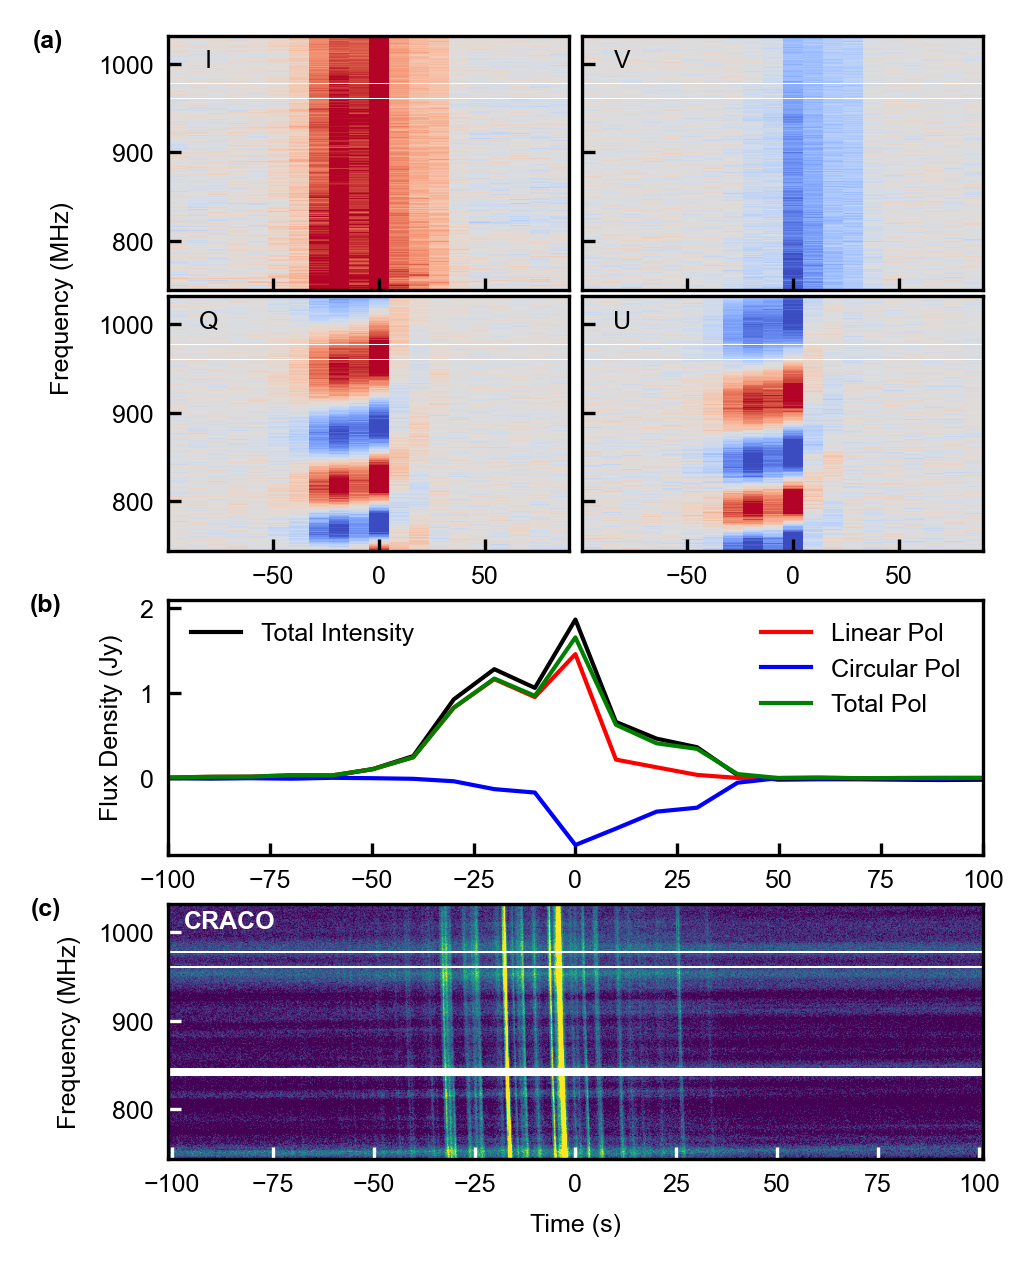

In [5]:
### include askap hardware dynamic spectra
fig = plt.figure(figsize=(8.9*cm, 12.35*cm))
gs = GridSpec(figure=fig, nrows=26, ncols=6, wspace=0.1, hspace=0.15)

ax = fig.add_subplot(gs[0:6, 0:3])
ax.imshow(
    Iplot.T, aspect="auto", cmap="coolwarm", vmax=clim, vmin=-clim, 
    origin="lower", extent=(hwt_plot[0], hwt_plot[-1], *frange),
    interpolation="none", 
)
ax.text(0.1, 0.9, "I", transform=ax.transAxes, ha="center", va="center")
ax.set_xticklabels([])

### add panel index
ax.text(-0.3, 0.98, "(a)", transform=ax.transAxes, ha="center", va="center", weight="bold")

ax = fig.add_subplot(gs[0:6, 3:6])
ax.imshow(
    Vplot.T, aspect="auto", cmap="coolwarm", vmax=clim, vmin=-clim, 
    origin="lower", extent=(hwt_plot[0], hwt_plot[-1], *frange),
    interpolation="none", 
)
ax.text(0.1, 0.9, "V", transform=ax.transAxes, ha="center", va="center")
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(gs[6:12, 0:3])
ax.imshow(
    Qplot.T, aspect="auto", cmap="coolwarm", vmax=clim, vmin=-clim, 
    origin="lower", extent=(hwt_plot[0], hwt_plot[-1], *frange),
    interpolation="none",
)
ax.text(0.1, 0.9, "Q", transform=ax.transAxes, ha="center", va="center")

ax = fig.add_subplot(gs[6:12, 3:6])
ax.imshow(
    Uplot.T, aspect="auto", cmap="coolwarm", vmax=clim, vmin=-clim, 
    origin="lower", extent=(hwt_plot[0], hwt_plot[-1], *frange), 
    interpolation="none",
)
ax.text(0.1, 0.9, "U", transform=ax.transAxes, ha="center", va="center")
ax.set_yticklabels([])

plt.text(
    0.025, 0.7, "Frequency (MHz)", transform=fig.transFigure, rotation=90,
    va="center", ha="center"
)

### light curve data
ax = fig.add_subplot(gs[13:19, :])

linewidth = 1.
l1, = ax.plot(lwt_plot, Ic / pbcor, color="k", label="Total Intensity", lw=linewidth)
l2, = ax.plot(lwt_plot, Lc / pbcor, color="red", label="Linear Pol", lw=linewidth)
l3, = ax.plot(lwt_plot, Vc / pbcor, color="blue", label="Circular Pol", lw=linewidth)
l4, = ax.plot(lwt_plot, np.sqrt(Lc**2 + Vc**2) / pbcor, color="green", label="Total Pol", lw=linewidth)

leg1 = ax.legend(handles=[l1], loc="upper left", frameon=False)
ax.add_artist(leg1)
leg2 = ax.legend(handles=[l2, l3, l4], loc="upper right", frameon=False)

ax.set_xlim(-100, 100)
ax.set_ylim(-0.9, 2.1)

### add panel index
ax.text(-0.15, 0.98, "(b)", transform=ax.transAxes, ha="center", va="center", weight="bold")

ax.set_ylabel(r"Flux Density (Jy)")

### craco data
ax = fig.add_subplot(gs[20:26, :])
ax.imshow(
    crplot.T, aspect="auto", vmax=1.0, vmin=-0.01, origin="lower", #interpolation="none",
    cmap="viridis", extent=(crt_plot[0], crt_plot[-1], *frange)
)
ax.set_ylabel("Frequency (MHz)")
ax.set_xlabel("Time (s)")
ax.tick_params(color="white")

ax.text(0.02, 0.93, "CRACO", transform=ax.transAxes, ha="left", va="center", color="white", weight="bold")

### add panel index
ax.text(-0.15, 0.98, "(c)", transform=ax.transAxes, ha="center", va="center", weight="bold")

### save figure
# fig.savefig("./askap_discovery_plot.pdf", bbox_inches="tight", dpi=300)

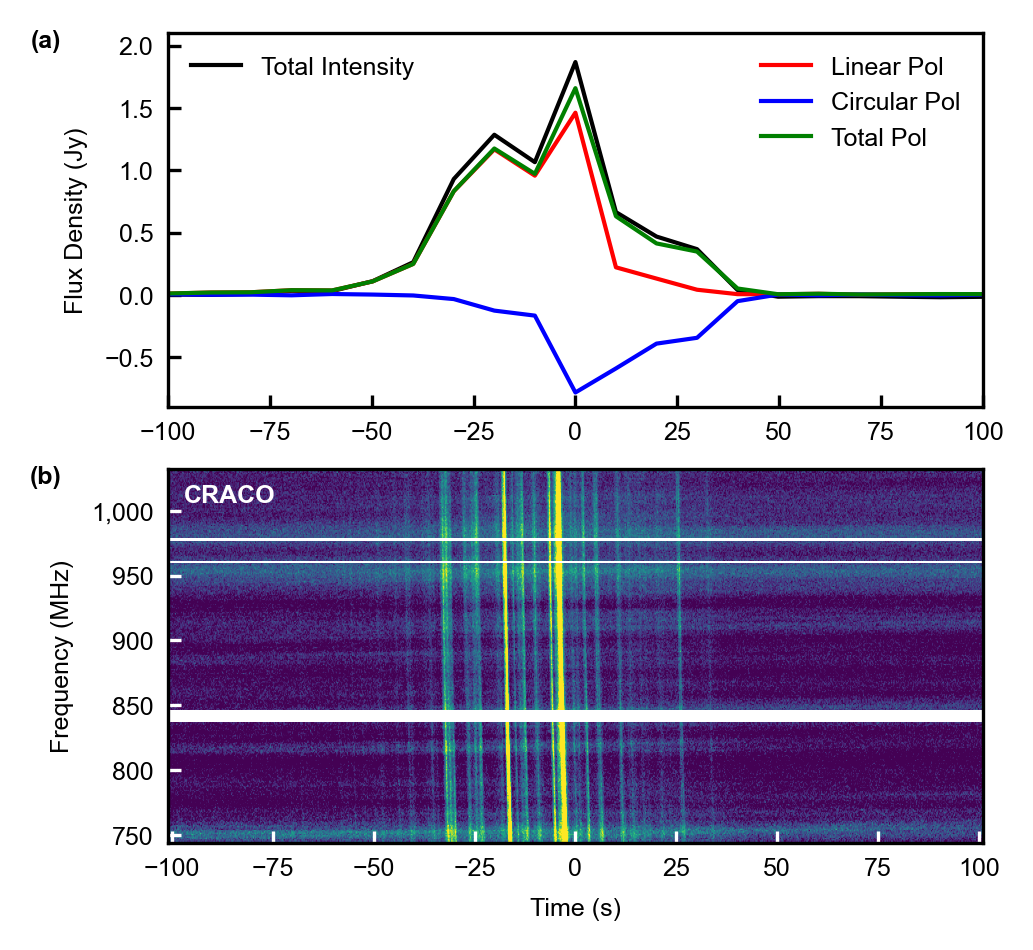

In [8]:
fig = plt.figure(figsize=(8.9*cm, 8.9*cm))
gs = GridSpec(figure=fig, nrows=13, ncols=6, wspace=0.1, hspace=0.)

### light curve data
ax = fig.add_subplot(gs[0:6, :])

linewidth = 1.
l1, = ax.plot(lwt_plot, Ic / pbcor, color="k", label="Total Intensity", lw=linewidth)
l2, = ax.plot(lwt_plot, Lc / pbcor, color="red", label="Linear Pol", lw=linewidth)
l3, = ax.plot(lwt_plot, Vc / pbcor, color="blue", label="Circular Pol", lw=linewidth)
l4, = ax.plot(lwt_plot, np.sqrt(Lc**2 + Vc**2) / pbcor, color="green", label="Total Pol", lw=linewidth)

leg1 = ax.legend(handles=[l1], loc="upper left", frameon=False)
ax.add_artist(leg1)
leg2 = ax.legend(handles=[l2, l3, l4], loc="upper right", frameon=False)

ax.set_xlim(-100, 100)
ax.set_ylim(-0.9, 2.1)

### add panel index
ax.text(-0.15, 0.98, "(a)", transform=ax.transAxes, ha="center", va="center", weight="bold")

ax.set_ylabel(r"Flux Density (Jy)")

### craco data
ax = fig.add_subplot(gs[7:13, :])
ax.imshow(
    crplot.T, aspect="auto", vmax=1.0, vmin=-0.01, origin="lower", #interpolation="none",
    cmap="viridis", extent=(crt_plot[0], crt_plot[-1], *frange)
)
ax.set_ylabel("Frequency (MHz)")
ax.set_xlabel("Time (s)")
ax.tick_params(color="white")
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.text(0.02, 0.93, "CRACO", transform=ax.transAxes, ha="left", va="center", color="white", weight="bold")

### add panel index
ax.text(-0.15, 0.98, "(b)", transform=ax.transAxes, ha="center", va="center", weight="bold")

### save figure
fig.savefig("./askap_discovery_plot.pdf", bbox_inches="tight", dpi=300)

### Rotation Measure Estimation

In [7]:
from vis_ds import DynamicSpectra

from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean

import numpy as np
import matplotlib.pyplot as plt

Discovery observation (SB55237)

In [8]:
ds = DynamicSpectra("../data/askap_SB55237.beam19.J1832-0911.pkl", calCASA=False)
I, Q, U, V = ds.get_stokes()
freqs = ds.freqs

Text(0, 0.5, 'Flux Density (Jy)')

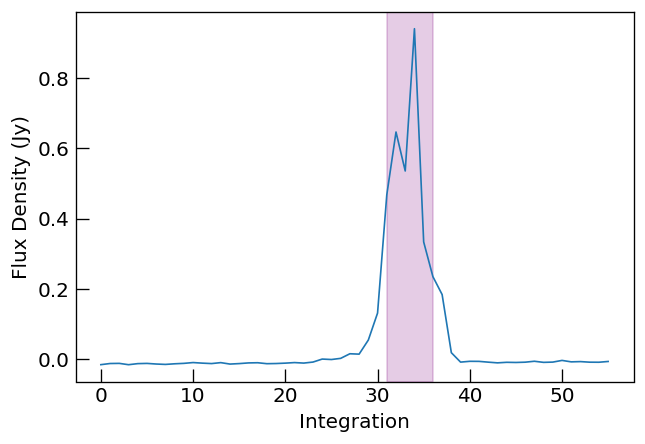

In [9]:
### slice the data so that we only run RM synthesis on the pulse part
plt.figure(figsize=(6, 4), dpi=120)
plt.plot(np.nanmean(I, axis=1))
plt.axvspan(xmin=31, xmax=36, color="purple", alpha=0.2)
plt.xlabel("Integration")
plt.ylabel("Flux Density (Jy)")

In [10]:
pQ = np.nanmean(Q[31:37, :], axis=0)
pU = np.nanmean(U[31:37, :], axis=0)

dQs = 0.016; dUs = 0.016
cleanthres = 3

data = [freqs, pQ, pU, dQs, dUs]

mDict, aDict = run_rmsynth(data)
mDict_cl, aDict_cl = run_rmclean(mDict, aDict, -cleanthres)

RM = mDict_cl["phiPeakPIfit_rm2"]; dRM = mDict_cl["dPhiPeakPIfit_rm2"]
PA = mDict_cl["polAngle0Fit_deg"]; dPA = mDict_cl["dPolAngle0Fit_deg"]
# PA = np.deg2rad(PA)

print("rotation measure: ", RM, "+/-", dRM)
print("position angle: ", PA, "+/-", dPA)

rotation measure:  89.1016492493916 +/- 0.06441706399244523
position angle:  39.4842185021904 +/- 0.40638379292403426


The observation with the brightest pulse (SB58609)

In [11]:
ds = DynamicSpectra("../data/askap_SB58609.beam13.J1832-0911.pkl", calCASA=False)
I, Q, U, V = ds.get_stokes()
freqs = ds.freqs

(990.0, 1020.0)

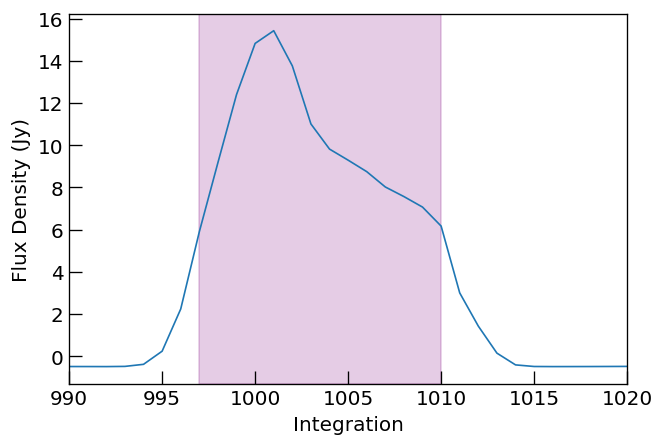

In [12]:
### slice the data so that we only run RM synthesis on the pulse part
plt.figure(figsize=(6, 4), dpi=120)
plt.plot(np.nanmean(I, axis=1))
plt.axvspan(xmin=997, xmax=1010, color="purple", alpha=0.2)
plt.xlabel("Integration")
plt.ylabel("Flux Density (Jy)")

plt.xlim(990, 1020)

In [13]:
pQ = np.nanmean(Q[997:1011, :], axis=0)
pU = np.nanmean(U[997:1011, :], axis=0)

dQs = 0.016; dUs = 0.016
cleanthres = 3

data = [freqs, pQ, pU, dQs, dUs]

mDict, aDict = run_rmsynth(data)
mDict_cl, aDict_cl = run_rmclean(mDict, aDict, -cleanthres)

RM = mDict_cl["phiPeakPIfit_rm2"]; dRM = mDict_cl["dPhiPeakPIfit_rm2"]
PA = mDict_cl["polAngle0Fit_deg"]; dPA = mDict_cl["dPolAngle0Fit_deg"]
# PA = np.deg2rad(PA)

print("rotation measure: ", RM, "+/-", dRM)
print("position angle: ", PA, "+/-", dPA)

rotation measure:  90.50756602986044 +/- 0.004202679567807088
position angle:  11.117406466209104 +/- 0.023286017728263015
